In [ ]:
!pip install GPUtil
!pip install codecarbon

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=0b304dd0400d1460dea1f898d5e8d3334d453ffdd6e0909bc5cb2ed3b56b3d97
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built GPUtil
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 3.1.0
    Uninstalling termcolor-3.1.0:
      Successfully uninstalled termcolor-3.1.0
  Attempting uninstall: psutil
    Found 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import KFold, train_test_split, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import time
import psutil

import GPUtil

from codecarbon import EmissionsTracker

In [ ]:
database = pd.read_csv('/content/drive/MyDrive/Pesquisa/Código/Aplicação/preprocessed_database.csv')

In [ ]:
database

,BidsPortfolioManager,BidsApi,BidsManual,Age,AppliedAmount,Interest,LoanDuration,IncomeFromPrincipalEmployer,IncomeFromPension,IncomeFromFamilyAllowance,...,HomeOwnershipType_2.0,HomeOwnershipType_3.0,HomeOwnershipType_4.0,HomeOwnershipType_5.0,HomeOwnershipType_6.0,HomeOwnershipType_7.0,HomeOwnershipType_8.0,HomeOwnershipType_9.0,HomeOwnershipType_10.0,NewCreditCustomer_True
0,970,1150,5.0,53,2125.0,20.97,60,0.0,301.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1295,0,1705.0,50,3000.0,17.12,60,900.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2700,565,5835.0,44,10630.0,13.67,60,600.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
3,1115,0,385.0,42,1500.0,40.40,60,863.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
4,305,0,785.0,34,1595.0,68.39,48,0.0,697.0,0.0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121456,2000,0,0.0,38,2000.0,33.79,60,1500.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
121457,6215,70,1155.0,37,7440.0,24.52,60,2172.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
121458,430,0,1055.0,37,1595.0,64.51,60,1550.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
121459,3000,0,0.0,58,3000.0,21.62,60,350.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
y = database['Status']
X = database.drop('Status', axis=1)

# Auxiliary functions

In [ ]:
def analyse_metrics(y_predict, y_test):
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    accuracy = accuracy_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)


    return {
                    "Accuracy": accuracy,
                    "F1 Score" : f1,
                    "Precision": precision,
                    "Recall": recall,
    }

In [ ]:
def get_cpu():
    return psutil.cpu_percent(interval=1)

def get_gpu():
    gpus = GPUtil.getGPUs()
    print("GPU:", gpus)
    if len(gpus) > 0:
        return sum(gpu.load for gpu in gpus) / len(gpus) * 100
    else:
        return 0


def get_ram():
    memory = psutil.virtual_memory()
    return memory.used / (1024**3)

In [ ]:
def emissions_analysis(tracker, name):

    print(f"Avaliando Emissões: {name}")

    emission = tracker.final_emissions
    energy = tracker._total_energy.kWh
    cpu_use = tracker._total_cpu_energy.kWh
    gpu_use = get_gpu()
    ram_use = tracker._total_ram_energy.kWh

    return {"Model" : name, "Energy consumption (kWh)" : energy,
                     "Carbon Emissions (kg CO2)" : emission,
                     "CPU usage (kWh)" : cpu_use,
                     "GPU usage (%)" : gpu_use,
                     "Memory usage (kWh)" : ram_use}

In [ ]:
def train_model_with_timing(model, X_train, y_train, X_test):

    start_time = time.time()

    traker = EmissionsTracker()
    traker.start()

    model.fit(X_train, y_train)

    traker.stop()

    training_time = time.time() - start_time

    emissions_analyse_model = emissions_analysis(traker, model)

    y_predict = model.predict(X_test)

    return y_predict, training_time, emissions_analyse_model

# Cross-validation and gridsearch

In [ ]:
# setting parameters

param_DT = {'max_depth': range(1, 11)}
param_LR = {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']}
param_RF = {'n_estimators': [100], 'max_depth': [None, 10], 'criterion': ['gini']}
param_XGB = {'n_estimators': [50, 100],'max_depth': [3, 5, 7],'learning_rate': [0.1, 0.2]}
param_MLP = {'hidden_layer_sizes': [(100,), (50, 50)],'activation': ['relu'],'solver': ['adam'],'alpha': [0.0001]}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

metrics_DT = []
metrics_LR = []
metrics_RF = []
metrics_XGB = []
metrics_MLP = []

# listas para armazenar o tempo
time_train_DT = []
time_val_DT = []

time_train_LR = []
time_val_LR = []

time_train_RF = []
time_val_RF = []

time_train_XGB = []
time_val_XGB = []

time_train_MLP = []
time_val_MLP = []

#listas para armazenar as emissões

emissoes_train_DT = []
emissoes_val_DT = []

emissoes_train_LR = []
emissoes_val_LR = []

emissoes_train_RF = []
emissoes_val_RF = []

emissoes_train_XGB = []
emissoes_val_XGB = []

for train_indes, test_index in kfold.split(X):
  X_train, X_test = X.iloc[train_indes], X.iloc[test_index]
  y_train, y_test = y.iloc[train_indes], y.iloc[test_index]

  X_train_divided, X_val, y_train_divided, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

  scaler = MinMaxScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  X_train_divided = scaler.fit_transform(X_train_divided)
  X_val = scaler.transform(X_val)

  # defining the lists to store the accuracy values ​​to find the best hyperparameters for each algorithm

  accuracy_DT = []
  par_DT = []

  accuracy_LR = []
  par_LR = []

  accuracy_RF = []
  par_RF = []

  accuracy_XGB = []
  par_XGB = []

  accuracy_MLP = []
  par_MLP = []


#gridsearch

  # Decision Tree
  for params in ParameterGrid(param_DT):
    dt_model = DecisionTreeClassifier(criterion="gini", max_depth=params['max_depth'], random_state=42)
    y_pred, val_end_time_DT, emissions_analyse_val_DT = train_model_with_timing(dt_model, X_train_divided, y_train_divided, X_val)
    accuracy_DT.append(accuracy_score(y_val, y_pred))
    par_DT.append(params)
    time_val_DT.append(val_end_time_DT)
    emissoes_val_DT.append(emissions_analyse_val_DT)

  print(par_DT[accuracy_DT.index(max(accuracy_DT))])

  dt_model_best = DecisionTreeClassifier(criterion="gini", max_depth=par_DT[accuracy_DT.index(max(accuracy_DT))]['max_depth'], random_state=42)
  y_predict_DT, training_end_time_DT, emissions_analyse_train_DT = train_model_with_timing(dt_model_best, X_train, y_train, X_test)
  metrics_DT.append(analyse_metrics(y_predict_DT, y_test))
  time_train_DT.append(training_end_time_DT)
  emissoes_train_DT.append(emissions_analyse_train_DT)

    # Random Forest
  for params in ParameterGrid(param_RF):
    rf_model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'], criterion=params['criterion'], random_state=42)
    y_pred, val_end_time_RF, emissions_analyse_val_RF = train_model_with_timing(rf_model, X_train_divided, y_train_divided, X_val)
    accuracy_RF.append(accuracy_score(y_val, y_pred))
    par_RF.append(params)
    time_val_RF.append(val_end_time_RF)
    emissoes_val_RF.append(emissions_analyse_val_RF)

  print(par_RF[accuracy_RF.index(max(accuracy_RF))])

  rf_model_best = RandomForestClassifier(n_estimators=par_RF[accuracy_RF.index(max(accuracy_RF))]['n_estimators'], max_depth=par_RF[accuracy_RF.index(max(accuracy_RF))]['max_depth'],
                                         criterion=par_RF[accuracy_RF.index(max(accuracy_RF))]['criterion'], random_state=42)
  y_predict_RF, training_end_time_RF, emissions_analyse_train_RF = train_model_with_timing(rf_model_best, X_train, y_train, X_test)
  metrics_RF.append(analyse_metrics(y_predict_RF, y_test))
  time_train_RF.append(training_end_time_RF)
  emissoes_train_RF.append(emissions_analyse_train_RF)

    # Logistic Regression
  for params in ParameterGrid(param_LR):
    lr_model = LogisticRegression(C=params['C'], penalty=params['penalty'], solver=params['solver'], random_state=42)
    y_pred, val_end_time_LR, emissions_analyse_val_LR = train_model_with_timing(lr_model, X_train_divided, y_train_divided, X_val)
    accuracy_LR.append(accuracy_score(y_val, y_pred))
    par_LR.append(params)
    time_val_LR.append(val_end_time_LR)
    emissoes_val_LR.append(emissions_analyse_val_LR)

  print(par_LR[accuracy_LR.index(max(accuracy_LR))])

  lr_model_best = LogisticRegression(C=par_LR[accuracy_LR.index(max(accuracy_LR))]['C'], penalty=par_LR[accuracy_LR.index(max(accuracy_LR))]['penalty'],
                                     solver=par_LR[accuracy_LR.index(max(accuracy_LR))]['solver'], random_state=42)
  y_predict_LR, training_end_time_LR, emissions_analyse_train_LR = train_model_with_timing(lr_model_best, X_train, y_train, X_test)
  metrics_LR.append(analyse_metrics(y_predict_LR, y_test))
  time_train_LR.append(training_end_time_LR)
  emissoes_train_LR.append(emissions_analyse_train_LR)

    # XGBoost
  for params in ParameterGrid(param_XGB):
    xgb_model = XGBClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'], learning_rate=params['learning_rate'], random_state=42)
    y_pred, val_end_time_XGB, emissions_analyse_val_XGB = train_model_with_timing(xgb_model, X_train_divided, y_train_divided, X_val)
    accuracy_XGB.append(accuracy_score(y_val, y_pred))
    par_XGB.append(params)
    time_val_XGB.append(val_end_time_XGB)
    emissoes_val_XGB.append(emissions_analyse_val_XGB)

  print(par_XGB[accuracy_XGB.index(max(accuracy_XGB))])

  xgb_model_best = XGBClassifier(n_estimators=par_XGB[accuracy_XGB.index(max(accuracy_XGB))]['n_estimators'], max_depth=par_XGB[accuracy_XGB.index(max(accuracy_XGB))]['max_depth'],
                                 learning_rate=par_XGB[accuracy_XGB.index(max(accuracy_XGB))]['learning_rate'], random_state=42)
  y_predict_XGB, training_end_time_XGB, emissions_analyse_train_XGB = train_model_with_timing(xgb_model_best, X_train, y_train, X_test)
  metrics_XGB.append(analyse_metrics(y_predict_XGB, y_test))
  time_train_XGB.append(training_end_time_XGB)
  emissoes_train_XGB.append(emissions_analyse_train_XGB)



[codecarbon WARNING @ 13:51:11] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:51:11] [setup] RAM Tracking...
[codecarbon INFO @ 13:51:11] [setup] CPU Tracking...
[codecarbon WARNING @ 13:51:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:51:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:51:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:51:12] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:51:12] [setup] GPU Tracking...
[codecarbon INFO @ 13:51:12] No GPU found.
[codecarbon INFO @ 13:51:12] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Avaliando Emissões: DecisionTreeClassifier(max_depth=1, random_state=42)
GPU: []


[codecarbon WARNING @ 13:51:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:51:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:51:14] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:51:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:51:14] [setup] GPU Tracking...
[codecarbon INFO @ 13:51:14] No GPU found.
[codecarbon INFO @ 13:51:14] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:51:14] >>> Tracker's metadata:
[codecarbon INFO @ 13:51:14]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=2, random_state=42)
GPU: []


[codecarbon WARNING @ 13:51:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:51:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:51:16] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:51:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:51:16] [setup] GPU Tracking...
[codecarbon INFO @ 13:51:16] No GPU found.
[codecarbon INFO @ 13:51:16] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:51:16] >>> Tracker's metadata:
[codecarbon INFO @ 13:51:16]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=3, random_state=42)
GPU: []


[codecarbon WARNING @ 13:51:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:51:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:51:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:51:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:51:18] [setup] GPU Tracking...
[codecarbon INFO @ 13:51:18] No GPU found.
[codecarbon INFO @ 13:51:18] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:51:18] >>> Tracker's metadata:
[codecarbon INFO @ 13:51:18]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=4, random_state=42)
GPU: []


[codecarbon WARNING @ 13:51:21] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:51:21] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:51:21] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:51:21] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:51:21] [setup] GPU Tracking...
[codecarbon INFO @ 13:51:21] No GPU found.
[codecarbon INFO @ 13:51:21] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:51:21] >>> Tracker's metadata:
[codecarbon INFO @ 13:51:21]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=5, random_state=42)
GPU: []


[codecarbon WARNING @ 13:51:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:51:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:51:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:51:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:51:24] [setup] GPU Tracking...
[codecarbon INFO @ 13:51:24] No GPU found.
[codecarbon INFO @ 13:51:24] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:51:24] >>> Tracker's metadata:
[codecarbon INFO @ 13:51:24]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=6, random_state=42)
GPU: []


[codecarbon WARNING @ 13:51:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:51:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:51:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:51:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:51:26] [setup] GPU Tracking...
[codecarbon INFO @ 13:51:26] No GPU found.
[codecarbon INFO @ 13:51:26] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:51:26] >>> Tracker's metadata:
[codecarbon INFO @ 13:51:26]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=7, random_state=42)
GPU: []


[codecarbon WARNING @ 13:51:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:51:28] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:51:28] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:51:28] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:51:28] [setup] GPU Tracking...
[codecarbon INFO @ 13:51:28] No GPU found.
[codecarbon INFO @ 13:51:28] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:51:28] >>> Tracker's metadata:
[codecarbon INFO @ 13:51:28]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=8, random_state=42)
GPU: []


[codecarbon WARNING @ 13:51:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:51:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:51:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:51:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:51:30] [setup] GPU Tracking...
[codecarbon INFO @ 13:51:30] No GPU found.
[codecarbon INFO @ 13:51:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:51:30] >>> Tracker's metadata:
[codecarbon INFO @ 13:51:30]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=9, random_state=42)
GPU: []


[codecarbon WARNING @ 13:51:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:51:33] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:51:33] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:51:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:51:33] [setup] GPU Tracking...
[codecarbon INFO @ 13:51:33] No GPU found.
[codecarbon INFO @ 13:51:33] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:51:33] >>> Tracker's metadata:
[codecarbon INFO @ 13:51:33]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=10, random_state=42)
GPU: []
{'max_depth': 7}


[codecarbon WARNING @ 13:51:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:51:35] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:51:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:51:35] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:51:35] [setup] GPU Tracking...
[codecarbon INFO @ 13:51:35] No GPU found.
[codecarbon INFO @ 13:51:35] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:51:35] >>> Tracker's metadata:
[codecarbon INFO @ 13:51:35]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=7, random_state=42)
GPU: []


[codecarbon WARNING @ 13:51:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:51:38] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:51:38] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:51:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:51:38] [setup] GPU Tracking...
[codecarbon INFO @ 13:51:38] No GPU found.
[codecarbon INFO @ 13:51:38] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:51:38] >>> Tracker's metadata:
[codecarbon INFO @ 13:51:38]   Platform system: Linux-6

Avaliando Emissões: RandomForestClassifier(random_state=42)
GPU: []


[codecarbon WARNING @ 13:52:04] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:52:04] [setup] RAM Tracking...
[codecarbon INFO @ 13:52:04] [setup] CPU Tracking...
[codecarbon WARNING @ 13:52:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:52:05] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:52:05] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:52:05] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:52:05] [setup] GPU Tracking...
[codecarbon INFO @ 13:52:05] No GPU found.
[codecarbon INFO @ 13:52:05] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Avaliando Emissões: RandomForestClassifier(max_depth=10, random_state=42)
GPU: []


[codecarbon WARNING @ 13:52:15] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:52:15] [setup] RAM Tracking...
[codecarbon INFO @ 13:52:15] [setup] CPU Tracking...


{'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}


[codecarbon WARNING @ 13:52:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:52:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:52:16] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:52:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:52:16] [setup] GPU Tracking...
[codecarbon INFO @ 13:52:16] No GPU found.
[codecarbon INFO @ 13:52:16] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:52:16] >>> Tracker's metadata:
[codecarbon INFO @ 13:52:16]   Platform system: Linux-6

Avaliando Emissões: RandomForestClassifier(random_state=42)
GPU: []


[codecarbon WARNING @ 13:52:48] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:52:48] [setup] RAM Tracking...
[codecarbon INFO @ 13:52:48] [setup] CPU Tracking...
[codecarbon WARNING @ 13:52:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:52:49] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:52:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:52:49] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:52:49] [setup] GPU Tracking...
[codecarbon INFO @ 13:52:49] No GPU found.
[codecarbon INFO @ 13:52:49] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Avaliando Emissões: LogisticRegression(C=0.1, random_state=42)
GPU: []


[codecarbon WARNING @ 13:52:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:52:52] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:52:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:52:52] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:52:52] [setup] GPU Tracking...
[codecarbon INFO @ 13:52:52] No GPU found.
[codecarbon INFO @ 13:52:52] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:52:52] >>> Tracker's metadata:
[codecarbon INFO @ 13:52:52]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=0.1, random_state=42, solver='liblinear')
GPU: []


[codecarbon WARNING @ 13:52:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:52:55] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:52:55] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:52:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:52:55] [setup] GPU Tracking...
[codecarbon INFO @ 13:52:55] No GPU found.
[codecarbon INFO @ 13:52:55] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:52:55] >>> Tracker's metadata:
[codecarbon INFO @ 13:52:55]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=1, random_state=42)
GPU: []


[codecarbon WARNING @ 13:53:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:53:02] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:53:02] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:53:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:53:02] [setup] GPU Tracking...
[codecarbon INFO @ 13:53:02] No GPU found.
[codecarbon INFO @ 13:53:02] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:53:02] >>> Tracker's metadata:
[codecarbon INFO @ 13:53:02]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=1, random_state=42, solver='liblinear')
GPU: []


[codecarbon WARNING @ 13:53:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:53:05] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:53:05] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:53:05] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:53:05] [setup] GPU Tracking...
[codecarbon INFO @ 13:53:05] No GPU found.
[codecarbon INFO @ 13:53:05] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:53:05] >>> Tracker's metadata:
[codecarbon INFO @ 13:53:05]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=10, random_state=42)
GPU: []


[codecarbon WARNING @ 13:53:10] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:53:10] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:53:10] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:53:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:53:10] [setup] GPU Tracking...
[codecarbon INFO @ 13:53:10] No GPU found.
[codecarbon INFO @ 13:53:10] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:53:10] >>> Tracker's metadata:
[codecarbon INFO @ 13:53:10]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=10, random_state=42, solver='liblinear')
GPU: []
{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


[codecarbon WARNING @ 13:53:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:53:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:53:16] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:53:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:53:16] [setup] GPU Tracking...
[codecarbon INFO @ 13:53:16] No GPU found.
[codecarbon INFO @ 13:53:16] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:53:16] >>> Tracker's metadata:
[codecarbon INFO @ 13:53:16]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=0.1, random_state=42, solver='liblinear')
GPU: []


[codecarbon WARNING @ 13:53:19] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:53:19] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:53:19] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:53:19] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:53:19] [setup] GPU Tracking...
[codecarbon INFO @ 13:53:19] No GPU found.
[codecarbon INFO @ 13:53:19] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:53:19] >>> Tracker's metadata:
[codecarbon INFO @ 13:53:19]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:53:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:53:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:53:22] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:53:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:53:22] [setup] GPU Tracking...
[codecarbon INFO @ 13:53:22] No GPU found.
[codecarbon INFO @ 13:53:22] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:53:22] >>> Tracker's metadata:
[codecarbon INFO @ 13:53:22]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:53:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:53:25] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:53:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:53:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:53:25] [setup] GPU Tracking...
[codecarbon INFO @ 13:53:25] No GPU found.
[codecarbon INFO @ 13:53:25] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:53:25] >>> Tracker's metadata:
[codecarbon INFO @ 13:53:25]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:53:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:53:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:53:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:53:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:53:30] [setup] GPU Tracking...
[codecarbon INFO @ 13:53:30] No GPU found.
[codecarbon INFO @ 13:53:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:53:30] >>> Tracker's metadata:
[codecarbon INFO @ 13:53:30]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:53:34] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:53:34] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:53:34] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:53:34] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:53:34] [setup] GPU Tracking...
[codecarbon INFO @ 13:53:34] No GPU found.
[codecarbon INFO @ 13:53:34] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:53:34] >>> Tracker's metadata:
[codecarbon INFO @ 13:53:34]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:53:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:53:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:53:37] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:53:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:53:37] [setup] GPU Tracking...
[codecarbon INFO @ 13:53:37] No GPU found.
[codecarbon INFO @ 13:53:37] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:53:37] >>> Tracker's metadata:
[codecarbon INFO @ 13:53:37]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:53:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:53:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:53:44] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:53:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:53:44] [setup] GPU Tracking...
[codecarbon INFO @ 13:53:44] No GPU found.
[codecarbon INFO @ 13:53:44] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:53:44] >>> Tracker's metadata:
[codecarbon INFO @ 13:53:44]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:53:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:53:47] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:53:47] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:53:47] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:53:47] [setup] GPU Tracking...
[codecarbon INFO @ 13:53:47] No GPU found.
[codecarbon INFO @ 13:53:47] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:53:47] >>> Tracker's metadata:
[codecarbon INFO @ 13:53:47]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:53:50] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:53:50] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:53:50] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:53:50] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:53:50] [setup] GPU Tracking...
[codecarbon INFO @ 13:53:50] No GPU found.
[codecarbon INFO @ 13:53:50] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:53:50] >>> Tracker's metadata:
[codecarbon INFO @ 13:53:50]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:53:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:53:55] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:53:55] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:53:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:53:55] [setup] GPU Tracking...
[codecarbon INFO @ 13:53:55] No GPU found.
[codecarbon INFO @ 13:53:55] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:53:55] >>> Tracker's metadata:
[codecarbon INFO @ 13:53:55]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:54:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:54:00] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:54:00] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:54:00] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:54:00] [setup] GPU Tracking...
[codecarbon INFO @ 13:54:00] No GPU found.
[codecarbon INFO @ 13:54:00] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:54:00] >>> Tracker's metadata:
[codecarbon INFO @ 13:54:00]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:54:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:54:04] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:54:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:54:04] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:54:04] [setup] GPU Tracking...
[codecarbon INFO @ 13:54:04] No GPU found.
[codecarbon INFO @ 13:54:04] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:54:04] >>> Tracker's metadata:
[codecarbon INFO @ 13:54:04]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


[codecarbon WARNING @ 13:54:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:54:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:54:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:54:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:54:08] [setup] GPU Tracking...
[codecarbon INFO @ 13:54:08] No GPU found.
[codecarbon INFO @ 13:54:08] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:54:08] >>> Tracker's metadata:
[codecarbon INFO @ 13:54:08]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:54:14] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:54:14] [setup] RAM Tracking...
[codecarbon INFO @ 13:54:14] [setup] CPU Tracking...
[codecarbon WARNING @ 13:54:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:54:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:54:16] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:54:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:54:16] [setup] GPU Tracking...
[codecarbon INFO @ 13:54:16] No GPU found.
[codecarbon INFO @ 13:54:16] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Avaliando Emissões: DecisionTreeClassifier(max_depth=1, random_state=42)
GPU: []


[codecarbon WARNING @ 13:54:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:54:17] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:54:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:54:17] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:54:17] [setup] GPU Tracking...
[codecarbon INFO @ 13:54:17] No GPU found.
[codecarbon INFO @ 13:54:17] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:54:17] >>> Tracker's metadata:
[codecarbon INFO @ 13:54:17]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=2, random_state=42)
GPU: []


[codecarbon WARNING @ 13:54:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:54:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:54:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:54:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:54:18] [setup] GPU Tracking...
[codecarbon INFO @ 13:54:19] No GPU found.
[codecarbon INFO @ 13:54:19] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:54:19] >>> Tracker's metadata:
[codecarbon INFO @ 13:54:19]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=3, random_state=42)
GPU: []


[codecarbon WARNING @ 13:54:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:54:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:54:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:54:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:54:20] [setup] GPU Tracking...
[codecarbon INFO @ 13:54:20] No GPU found.
[codecarbon INFO @ 13:54:20] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:54:20] >>> Tracker's metadata:
[codecarbon INFO @ 13:54:20]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=4, random_state=42)
GPU: []


[codecarbon WARNING @ 13:54:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:54:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:54:22] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:54:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:54:22] [setup] GPU Tracking...
[codecarbon INFO @ 13:54:22] No GPU found.
[codecarbon INFO @ 13:54:22] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:54:22] >>> Tracker's metadata:
[codecarbon INFO @ 13:54:22]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=5, random_state=42)
GPU: []


[codecarbon WARNING @ 13:54:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:54:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:54:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:54:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:54:24] [setup] GPU Tracking...
[codecarbon INFO @ 13:54:24] No GPU found.
[codecarbon INFO @ 13:54:24] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:54:24] >>> Tracker's metadata:
[codecarbon INFO @ 13:54:24]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=6, random_state=42)
GPU: []


[codecarbon WARNING @ 13:54:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:54:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:54:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:54:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:54:27] [setup] GPU Tracking...
[codecarbon INFO @ 13:54:27] No GPU found.
[codecarbon INFO @ 13:54:27] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:54:27] >>> Tracker's metadata:
[codecarbon INFO @ 13:54:27]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=7, random_state=42)
GPU: []


[codecarbon WARNING @ 13:54:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:54:29] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:54:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:54:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:54:29] [setup] GPU Tracking...
[codecarbon INFO @ 13:54:29] No GPU found.
[codecarbon INFO @ 13:54:29] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:54:29] >>> Tracker's metadata:
[codecarbon INFO @ 13:54:29]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=8, random_state=42)
GPU: []


[codecarbon WARNING @ 13:54:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:54:31] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:54:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:54:31] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:54:31] [setup] GPU Tracking...
[codecarbon INFO @ 13:54:31] No GPU found.
[codecarbon INFO @ 13:54:31] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:54:31] >>> Tracker's metadata:
[codecarbon INFO @ 13:54:31]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=9, random_state=42)
GPU: []


[codecarbon WARNING @ 13:54:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:54:33] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:54:33] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:54:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:54:33] [setup] GPU Tracking...
[codecarbon INFO @ 13:54:33] No GPU found.
[codecarbon INFO @ 13:54:33] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:54:33] >>> Tracker's metadata:
[codecarbon INFO @ 13:54:33]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=10, random_state=42)
GPU: []
{'max_depth': 7}


[codecarbon WARNING @ 13:54:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:54:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:54:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:54:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:54:36] [setup] GPU Tracking...
[codecarbon INFO @ 13:54:36] No GPU found.
[codecarbon INFO @ 13:54:36] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:54:36] >>> Tracker's metadata:
[codecarbon INFO @ 13:54:36]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=7, random_state=42)
GPU: []


[codecarbon WARNING @ 13:54:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:54:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:54:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:54:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:54:39] [setup] GPU Tracking...
[codecarbon INFO @ 13:54:39] No GPU found.
[codecarbon INFO @ 13:54:39] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:54:39] >>> Tracker's metadata:
[codecarbon INFO @ 13:54:39]   Platform system: Linux-6

Avaliando Emissões: RandomForestClassifier(random_state=42)
GPU: []


[codecarbon WARNING @ 13:55:06] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:55:06] [setup] RAM Tracking...
[codecarbon INFO @ 13:55:06] [setup] CPU Tracking...
[codecarbon WARNING @ 13:55:07] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:55:07] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:55:07] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:55:07] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:55:07] [setup] GPU Tracking...
[codecarbon INFO @ 13:55:07] No GPU found.
[codecarbon INFO @ 13:55:07] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Avaliando Emissões: RandomForestClassifier(max_depth=10, random_state=42)
GPU: []
{'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}


[codecarbon WARNING @ 13:55:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:55:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:55:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:55:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:55:18] [setup] GPU Tracking...
[codecarbon INFO @ 13:55:18] No GPU found.
[codecarbon INFO @ 13:55:18] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:55:18] >>> Tracker's metadata:
[codecarbon INFO @ 13:55:18]   Platform system: Linux-6

Avaliando Emissões: RandomForestClassifier(random_state=42)
GPU: []


[codecarbon WARNING @ 13:55:50] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:55:50] [setup] RAM Tracking...
[codecarbon INFO @ 13:55:50] [setup] CPU Tracking...
[codecarbon WARNING @ 13:55:51] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:55:51] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:55:51] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:55:51] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:55:51] [setup] GPU Tracking...
[codecarbon INFO @ 13:55:51] No GPU found.
[codecarbon INFO @ 13:55:51] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Avaliando Emissões: LogisticRegression(C=0.1, random_state=42)
GPU: []


[codecarbon WARNING @ 13:55:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:55:54] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:55:54] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:55:54] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:55:54] [setup] GPU Tracking...
[codecarbon INFO @ 13:55:54] No GPU found.
[codecarbon INFO @ 13:55:54] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:55:54] >>> Tracker's metadata:
[codecarbon INFO @ 13:55:54]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=0.1, random_state=42, solver='liblinear')
GPU: []


[codecarbon WARNING @ 13:55:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:55:56] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:55:56] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:55:56] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:55:56] [setup] GPU Tracking...
[codecarbon INFO @ 13:55:56] No GPU found.
[codecarbon INFO @ 13:55:56] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:55:56] >>> Tracker's metadata:
[codecarbon INFO @ 13:55:56]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=1, random_state=42)
GPU: []


[codecarbon WARNING @ 13:56:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:56:02] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:56:02] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:56:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:56:02] [setup] GPU Tracking...
[codecarbon INFO @ 13:56:02] No GPU found.
[codecarbon INFO @ 13:56:02] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:56:02] >>> Tracker's metadata:
[codecarbon INFO @ 13:56:02]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=1, random_state=42, solver='liblinear')
GPU: []


[codecarbon WARNING @ 13:56:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:56:05] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:56:05] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:56:05] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:56:05] [setup] GPU Tracking...
[codecarbon INFO @ 13:56:05] No GPU found.
[codecarbon INFO @ 13:56:05] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:56:05] >>> Tracker's metadata:
[codecarbon INFO @ 13:56:05]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=10, random_state=42)
GPU: []


[codecarbon WARNING @ 13:56:10] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:56:10] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:56:10] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:56:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:56:10] [setup] GPU Tracking...
[codecarbon INFO @ 13:56:10] No GPU found.
[codecarbon INFO @ 13:56:10] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:56:10] >>> Tracker's metadata:
[codecarbon INFO @ 13:56:10]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=10, random_state=42, solver='liblinear')
GPU: []
{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


[codecarbon WARNING @ 13:56:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:56:15] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:56:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:56:15] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:56:15] [setup] GPU Tracking...
[codecarbon INFO @ 13:56:15] No GPU found.
[codecarbon INFO @ 13:56:15] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:56:15] >>> Tracker's metadata:
[codecarbon INFO @ 13:56:15]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=10, random_state=42)
GPU: []


[codecarbon WARNING @ 13:56:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:56:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:56:22] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:56:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:56:22] [setup] GPU Tracking...
[codecarbon INFO @ 13:56:22] No GPU found.
[codecarbon INFO @ 13:56:22] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:56:22] >>> Tracker's metadata:
[codecarbon INFO @ 13:56:22]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:56:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:56:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:56:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:56:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:56:24] [setup] GPU Tracking...
[codecarbon INFO @ 13:56:24] No GPU found.
[codecarbon INFO @ 13:56:24] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:56:24] >>> Tracker's metadata:
[codecarbon INFO @ 13:56:24]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:56:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:56:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:56:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:56:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:56:27] [setup] GPU Tracking...
[codecarbon INFO @ 13:56:27] No GPU found.
[codecarbon INFO @ 13:56:27] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:56:28] >>> Tracker's metadata:
[codecarbon INFO @ 13:56:28]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:56:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:56:32] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:56:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:56:32] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:56:32] [setup] GPU Tracking...
[codecarbon INFO @ 13:56:32] No GPU found.
[codecarbon INFO @ 13:56:32] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:56:32] >>> Tracker's metadata:
[codecarbon INFO @ 13:56:32]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:56:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:56:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:56:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:56:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:56:36] [setup] GPU Tracking...
[codecarbon INFO @ 13:56:36] No GPU found.
[codecarbon INFO @ 13:56:36] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:56:36] >>> Tracker's metadata:
[codecarbon INFO @ 13:56:36]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:56:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:56:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:56:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:56:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:56:39] [setup] GPU Tracking...
[codecarbon INFO @ 13:56:39] No GPU found.
[codecarbon INFO @ 13:56:39] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:56:39] >>> Tracker's metadata:
[codecarbon INFO @ 13:56:39]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:56:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:56:47] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:56:47] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:56:47] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:56:47] [setup] GPU Tracking...
[codecarbon INFO @ 13:56:47] No GPU found.
[codecarbon INFO @ 13:56:47] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:56:47] >>> Tracker's metadata:
[codecarbon INFO @ 13:56:47]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:56:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:56:49] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:56:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:56:49] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:56:49] [setup] GPU Tracking...
[codecarbon INFO @ 13:56:49] No GPU found.
[codecarbon INFO @ 13:56:49] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:56:49] >>> Tracker's metadata:
[codecarbon INFO @ 13:56:49]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:56:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:56:52] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:56:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:56:52] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:56:52] [setup] GPU Tracking...
[codecarbon INFO @ 13:56:52] No GPU found.
[codecarbon INFO @ 13:56:52] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:56:52] >>> Tracker's metadata:
[codecarbon INFO @ 13:56:52]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:56:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:56:57] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:56:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:56:57] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:56:57] [setup] GPU Tracking...
[codecarbon INFO @ 13:56:57] No GPU found.
[codecarbon INFO @ 13:56:57] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:56:57] >>> Tracker's metadata:
[codecarbon INFO @ 13:56:57]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:57:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:57:01] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:57:01] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:57:01] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:57:01] [setup] GPU Tracking...
[codecarbon INFO @ 13:57:01] No GPU found.
[codecarbon INFO @ 13:57:01] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:57:01] >>> Tracker's metadata:
[codecarbon INFO @ 13:57:01]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:57:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:57:04] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:57:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:57:04] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:57:04] [setup] GPU Tracking...
[codecarbon INFO @ 13:57:04] No GPU found.
[codecarbon INFO @ 13:57:04] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:57:04] >>> Tracker's metadata:
[codecarbon INFO @ 13:57:04]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


[codecarbon WARNING @ 13:57:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:57:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:57:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:57:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:57:08] [setup] GPU Tracking...
[codecarbon INFO @ 13:57:08] No GPU found.
[codecarbon INFO @ 13:57:08] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:57:08] >>> Tracker's metadata:
[codecarbon INFO @ 13:57:08]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:57:14] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:57:14] [setup] RAM Tracking...
[codecarbon INFO @ 13:57:14] [setup] CPU Tracking...
[codecarbon WARNING @ 13:57:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:57:15] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:57:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:57:15] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:57:15] [setup] GPU Tracking...
[codecarbon INFO @ 13:57:15] No GPU found.
[codecarbon INFO @ 13:57:15] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Avaliando Emissões: DecisionTreeClassifier(max_depth=1, random_state=42)
GPU: []


[codecarbon WARNING @ 13:57:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:57:17] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:57:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:57:17] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:57:17] [setup] GPU Tracking...
[codecarbon INFO @ 13:57:17] No GPU found.
[codecarbon INFO @ 13:57:17] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:57:17] >>> Tracker's metadata:
[codecarbon INFO @ 13:57:17]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=2, random_state=42)
GPU: []


[codecarbon WARNING @ 13:57:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:57:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:57:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:57:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:57:18] [setup] GPU Tracking...
[codecarbon INFO @ 13:57:18] No GPU found.
[codecarbon INFO @ 13:57:18] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:57:18] >>> Tracker's metadata:
[codecarbon INFO @ 13:57:18]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=3, random_state=42)
GPU: []


[codecarbon WARNING @ 13:57:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:57:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:57:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:57:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:57:20] [setup] GPU Tracking...
[codecarbon INFO @ 13:57:20] No GPU found.
[codecarbon INFO @ 13:57:20] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:57:20] >>> Tracker's metadata:
[codecarbon INFO @ 13:57:20]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=4, random_state=42)
GPU: []


[codecarbon WARNING @ 13:57:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:57:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:57:22] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:57:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:57:22] [setup] GPU Tracking...
[codecarbon INFO @ 13:57:22] No GPU found.
[codecarbon INFO @ 13:57:22] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:57:22] >>> Tracker's metadata:
[codecarbon INFO @ 13:57:22]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=5, random_state=42)
GPU: []


[codecarbon WARNING @ 13:57:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:57:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:57:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:57:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:57:24] [setup] GPU Tracking...
[codecarbon INFO @ 13:57:24] No GPU found.
[codecarbon INFO @ 13:57:24] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:57:24] >>> Tracker's metadata:
[codecarbon INFO @ 13:57:24]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=6, random_state=42)
GPU: []


[codecarbon WARNING @ 13:57:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:57:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:57:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:57:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:57:26] [setup] GPU Tracking...
[codecarbon INFO @ 13:57:26] No GPU found.
[codecarbon INFO @ 13:57:26] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:57:26] >>> Tracker's metadata:
[codecarbon INFO @ 13:57:26]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=7, random_state=42)
GPU: []


[codecarbon WARNING @ 13:57:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:57:28] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:57:28] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:57:28] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:57:28] [setup] GPU Tracking...
[codecarbon INFO @ 13:57:28] No GPU found.
[codecarbon INFO @ 13:57:28] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:57:28] >>> Tracker's metadata:
[codecarbon INFO @ 13:57:28]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=8, random_state=42)
GPU: []


[codecarbon WARNING @ 13:57:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:57:31] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:57:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:57:31] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:57:31] [setup] GPU Tracking...
[codecarbon INFO @ 13:57:31] No GPU found.
[codecarbon INFO @ 13:57:31] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:57:31] >>> Tracker's metadata:
[codecarbon INFO @ 13:57:31]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=9, random_state=42)
GPU: []


[codecarbon WARNING @ 13:57:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:57:33] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:57:33] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:57:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:57:33] [setup] GPU Tracking...
[codecarbon INFO @ 13:57:33] No GPU found.
[codecarbon INFO @ 13:57:33] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:57:33] >>> Tracker's metadata:
[codecarbon INFO @ 13:57:33]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=10, random_state=42)
GPU: []
{'max_depth': 8}


[codecarbon WARNING @ 13:57:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:57:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:57:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:57:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:57:36] [setup] GPU Tracking...
[codecarbon INFO @ 13:57:36] No GPU found.
[codecarbon INFO @ 13:57:36] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:57:36] >>> Tracker's metadata:
[codecarbon INFO @ 13:57:36]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=8, random_state=42)
GPU: []


[codecarbon WARNING @ 13:57:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:57:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:57:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:57:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:57:39] [setup] GPU Tracking...
[codecarbon INFO @ 13:57:39] No GPU found.
[codecarbon INFO @ 13:57:39] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:57:39] >>> Tracker's metadata:
[codecarbon INFO @ 13:57:39]   Platform system: Linux-6

Avaliando Emissões: RandomForestClassifier(random_state=42)
GPU: []


[codecarbon WARNING @ 13:58:05] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:58:05] [setup] RAM Tracking...
[codecarbon INFO @ 13:58:05] [setup] CPU Tracking...
[codecarbon WARNING @ 13:58:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:58:06] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:58:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:58:06] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:58:06] [setup] GPU Tracking...
[codecarbon INFO @ 13:58:06] No GPU found.
[codecarbon INFO @ 13:58:06] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Avaliando Emissões: RandomForestClassifier(max_depth=10, random_state=42)
GPU: []


[codecarbon WARNING @ 13:58:16] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:58:16] [setup] RAM Tracking...
[codecarbon INFO @ 13:58:16] [setup] CPU Tracking...


{'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}


[codecarbon WARNING @ 13:58:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:58:17] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:58:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:58:17] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:58:17] [setup] GPU Tracking...
[codecarbon INFO @ 13:58:17] No GPU found.
[codecarbon INFO @ 13:58:17] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:58:17] >>> Tracker's metadata:
[codecarbon INFO @ 13:58:17]   Platform system: Linux-6

Avaliando Emissões: RandomForestClassifier(random_state=42)
GPU: []


[codecarbon WARNING @ 13:58:51] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:58:51] [setup] RAM Tracking...
[codecarbon INFO @ 13:58:51] [setup] CPU Tracking...
[codecarbon WARNING @ 13:58:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:58:52] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:58:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:58:52] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:58:52] [setup] GPU Tracking...
[codecarbon INFO @ 13:58:52] No GPU found.
[codecarbon INFO @ 13:58:52] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Avaliando Emissões: LogisticRegression(C=0.1, random_state=42)
GPU: []


[codecarbon WARNING @ 13:58:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:58:55] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:58:55] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:58:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:58:55] [setup] GPU Tracking...
[codecarbon INFO @ 13:58:55] No GPU found.
[codecarbon INFO @ 13:58:55] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:58:55] >>> Tracker's metadata:
[codecarbon INFO @ 13:58:55]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=0.1, random_state=42, solver='liblinear')
GPU: []


[codecarbon WARNING @ 13:58:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:58:58] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:58:58] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:58:58] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:58:58] [setup] GPU Tracking...
[codecarbon INFO @ 13:58:58] No GPU found.
[codecarbon INFO @ 13:58:58] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:58:58] >>> Tracker's metadata:
[codecarbon INFO @ 13:58:58]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=1, random_state=42)
GPU: []


[codecarbon WARNING @ 13:59:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:59:03] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:59:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:59:03] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:59:03] [setup] GPU Tracking...
[codecarbon INFO @ 13:59:03] No GPU found.
[codecarbon INFO @ 13:59:03] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:59:03] >>> Tracker's metadata:
[codecarbon INFO @ 13:59:03]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=1, random_state=42, solver='liblinear')
GPU: []


[codecarbon WARNING @ 13:59:07] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:59:07] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:59:07] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:59:07] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:59:07] [setup] GPU Tracking...
[codecarbon INFO @ 13:59:07] No GPU found.
[codecarbon INFO @ 13:59:07] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:59:07] >>> Tracker's metadata:
[codecarbon INFO @ 13:59:07]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=10, random_state=42)
GPU: []


[codecarbon WARNING @ 13:59:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:59:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:59:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:59:12] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:59:12] [setup] GPU Tracking...
[codecarbon INFO @ 13:59:12] No GPU found.
[codecarbon INFO @ 13:59:12] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:59:12] >>> Tracker's metadata:
[codecarbon INFO @ 13:59:12]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=10, random_state=42, solver='liblinear')
GPU: []
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


[codecarbon WARNING @ 13:59:19] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:59:19] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:59:19] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:59:19] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:59:19] [setup] GPU Tracking...
[codecarbon INFO @ 13:59:19] No GPU found.
[codecarbon INFO @ 13:59:19] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:59:19] >>> Tracker's metadata:
[codecarbon INFO @ 13:59:19]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=10, random_state=42, solver='liblinear')
GPU: []


[codecarbon WARNING @ 13:59:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:59:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:59:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:59:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:59:27] [setup] GPU Tracking...
[codecarbon INFO @ 13:59:27] No GPU found.
[codecarbon INFO @ 13:59:27] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:59:27] >>> Tracker's metadata:
[codecarbon INFO @ 13:59:27]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:59:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:59:32] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:59:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:59:32] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:59:32] [setup] GPU Tracking...
[codecarbon INFO @ 13:59:32] No GPU found.
[codecarbon INFO @ 13:59:32] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:59:32] >>> Tracker's metadata:
[codecarbon INFO @ 13:59:32]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:59:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:59:35] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:59:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:59:35] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:59:35] [setup] GPU Tracking...
[codecarbon INFO @ 13:59:35] No GPU found.
[codecarbon INFO @ 13:59:35] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:59:35] >>> Tracker's metadata:
[codecarbon INFO @ 13:59:35]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:59:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:59:38] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:59:38] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:59:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:59:38] [setup] GPU Tracking...
[codecarbon INFO @ 13:59:38] No GPU found.
[codecarbon INFO @ 13:59:38] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:59:38] >>> Tracker's metadata:
[codecarbon INFO @ 13:59:38]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:59:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:59:41] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:59:41] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:59:41] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:59:41] [setup] GPU Tracking...
[codecarbon INFO @ 13:59:41] No GPU found.
[codecarbon INFO @ 13:59:41] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:59:41] >>> Tracker's metadata:
[codecarbon INFO @ 13:59:41]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:59:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:59:47] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:59:47] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:59:47] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:59:47] [setup] GPU Tracking...
[codecarbon INFO @ 13:59:47] No GPU found.
[codecarbon INFO @ 13:59:47] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:59:47] >>> Tracker's metadata:
[codecarbon INFO @ 13:59:47]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:59:51] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:59:51] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:59:51] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:59:51] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:59:51] [setup] GPU Tracking...
[codecarbon INFO @ 13:59:51] No GPU found.
[codecarbon INFO @ 13:59:51] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:59:51] >>> Tracker's metadata:
[codecarbon INFO @ 13:59:51]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 13:59:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:59:54] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:59:54] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:59:54] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:59:54] [setup] GPU Tracking...
[codecarbon INFO @ 13:59:54] No GPU found.
[codecarbon INFO @ 13:59:54] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:59:54] >>> Tracker's metadata:
[codecarbon INFO @ 13:59:54]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:00:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:00] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:00] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:00] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:00] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:00] No GPU found.
[codecarbon INFO @ 14:00:00] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:00:00] >>> Tracker's metadata:
[codecarbon INFO @ 14:00:00]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:00:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:03] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:03] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:03] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:03] No GPU found.
[codecarbon INFO @ 14:00:03] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:00:03] >>> Tracker's metadata:
[codecarbon INFO @ 14:00:03]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:00:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:06] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:06] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:06] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:06] No GPU found.
[codecarbon INFO @ 14:00:06] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:00:06] >>> Tracker's metadata:
[codecarbon INFO @ 14:00:06]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:00:11] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:11] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:11] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:11] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:11] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:11] No GPU found.
[codecarbon INFO @ 14:00:11] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:00:11] >>> Tracker's metadata:
[codecarbon INFO @ 14:00:11]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []
{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}


[codecarbon WARNING @ 14:00:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:15] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:15] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:15] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:15] No GPU found.
[codecarbon INFO @ 14:00:15] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:00:15] >>> Tracker's metadata:
[codecarbon INFO @ 14:00:15]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:00:19] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:00:19] [setup] RAM Tracking...
[codecarbon INFO @ 14:00:19] [setup] CPU Tracking...
[codecarbon WARNING @ 14:00:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:20] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:20] No GPU found.
[codecarbon INFO @ 14:00:20] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Avaliando Emissões: DecisionTreeClassifier(max_depth=1, random_state=42)
GPU: []


[codecarbon WARNING @ 14:00:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:22] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:22] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:22] No GPU found.
[codecarbon INFO @ 14:00:22] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:00:22] >>> Tracker's metadata:
[codecarbon INFO @ 14:00:22]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=2, random_state=42)
GPU: []


[codecarbon WARNING @ 14:00:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:24] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:24] No GPU found.
[codecarbon INFO @ 14:00:24] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:00:24] >>> Tracker's metadata:
[codecarbon INFO @ 14:00:24]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=3, random_state=42)
GPU: []


[codecarbon WARNING @ 14:00:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:26] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:26] No GPU found.
[codecarbon INFO @ 14:00:26] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:00:26] >>> Tracker's metadata:
[codecarbon INFO @ 14:00:26]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=4, random_state=42)
GPU: []


[codecarbon WARNING @ 14:00:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:27] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:27] No GPU found.
[codecarbon INFO @ 14:00:27] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:00:27] >>> Tracker's metadata:
[codecarbon INFO @ 14:00:27]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=5, random_state=42)
GPU: []


[codecarbon WARNING @ 14:00:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:29] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:29] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:29] No GPU found.
[codecarbon INFO @ 14:00:29] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:00:29] >>> Tracker's metadata:
[codecarbon INFO @ 14:00:29]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=6, random_state=42)
GPU: []


[codecarbon WARNING @ 14:00:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:31] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:31] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:31] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:31] No GPU found.
[codecarbon INFO @ 14:00:31] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:00:31] >>> Tracker's metadata:
[codecarbon INFO @ 14:00:31]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=7, random_state=42)
GPU: []


[codecarbon WARNING @ 14:00:34] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:34] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:34] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:34] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:34] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:34] No GPU found.
[codecarbon INFO @ 14:00:34] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:00:34] >>> Tracker's metadata:
[codecarbon INFO @ 14:00:34]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=8, random_state=42)
GPU: []


[codecarbon WARNING @ 14:00:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:36] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:36] No GPU found.
[codecarbon INFO @ 14:00:36] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:00:36] >>> Tracker's metadata:
[codecarbon INFO @ 14:00:36]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=9, random_state=42)
GPU: []


[codecarbon WARNING @ 14:00:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:39] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:39] No GPU found.
[codecarbon INFO @ 14:00:39] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:00:39] >>> Tracker's metadata:
[codecarbon INFO @ 14:00:39]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=10, random_state=42)
GPU: []
{'max_depth': 7}


[codecarbon WARNING @ 14:00:42] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:42] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:42] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:42] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:42] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:42] No GPU found.
[codecarbon INFO @ 14:00:42] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:00:42] >>> Tracker's metadata:
[codecarbon INFO @ 14:00:42]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=7, random_state=42)
GPU: []


[codecarbon WARNING @ 14:00:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:00:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:00:44] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:00:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:00:44] [setup] GPU Tracking...
[codecarbon INFO @ 14:00:44] No GPU found.
[codecarbon INFO @ 14:00:44] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:00:44] >>> Tracker's metadata:
[codecarbon INFO @ 14:00:44]   Platform system: Linux-6

Avaliando Emissões: RandomForestClassifier(random_state=42)
GPU: []


[codecarbon WARNING @ 14:01:12] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:01:12] [setup] RAM Tracking...
[codecarbon INFO @ 14:01:12] [setup] CPU Tracking...
[codecarbon WARNING @ 14:01:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:01:13] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:01:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:01:13] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:01:13] [setup] GPU Tracking...
[codecarbon INFO @ 14:01:13] No GPU found.
[codecarbon INFO @ 14:01:13] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Avaliando Emissões: RandomForestClassifier(max_depth=10, random_state=42)
GPU: []


[codecarbon WARNING @ 14:01:25] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:01:25] [setup] RAM Tracking...
[codecarbon INFO @ 14:01:25] [setup] CPU Tracking...


{'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}


[codecarbon WARNING @ 14:01:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:01:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:01:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:01:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:01:26] [setup] GPU Tracking...
[codecarbon INFO @ 14:01:26] No GPU found.
[codecarbon INFO @ 14:01:26] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:01:26] >>> Tracker's metadata:
[codecarbon INFO @ 14:01:26]   Platform system: Linux-6

Avaliando Emissões: RandomForestClassifier(random_state=42)
GPU: []


[codecarbon WARNING @ 14:01:57] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:01:57] [setup] RAM Tracking...
[codecarbon INFO @ 14:01:57] [setup] CPU Tracking...
[codecarbon WARNING @ 14:01:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:01:59] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:01:59] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:01:59] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:01:59] [setup] GPU Tracking...
[codecarbon INFO @ 14:01:59] No GPU found.
[codecarbon INFO @ 14:01:59] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Avaliando Emissões: LogisticRegression(C=0.1, random_state=42)
GPU: []


[codecarbon WARNING @ 14:02:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:02:03] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:02:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:02:03] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:02:03] [setup] GPU Tracking...
[codecarbon INFO @ 14:02:03] No GPU found.
[codecarbon INFO @ 14:02:03] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:02:03] >>> Tracker's metadata:
[codecarbon INFO @ 14:02:03]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=0.1, random_state=42, solver='liblinear')
GPU: []


[codecarbon WARNING @ 14:02:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:02:06] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:02:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:02:06] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:02:06] [setup] GPU Tracking...
[codecarbon INFO @ 14:02:06] No GPU found.
[codecarbon INFO @ 14:02:06] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:02:06] >>> Tracker's metadata:
[codecarbon INFO @ 14:02:06]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=1, random_state=42)
GPU: []


[codecarbon WARNING @ 14:02:10] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:02:10] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:02:10] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:02:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:02:10] [setup] GPU Tracking...
[codecarbon INFO @ 14:02:10] No GPU found.
[codecarbon INFO @ 14:02:10] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:02:10] >>> Tracker's metadata:
[codecarbon INFO @ 14:02:10]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=1, random_state=42, solver='liblinear')
GPU: []


[codecarbon WARNING @ 14:02:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:02:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:02:14] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:02:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:02:14] [setup] GPU Tracking...
[codecarbon INFO @ 14:02:14] No GPU found.
[codecarbon INFO @ 14:02:14] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:02:14] >>> Tracker's metadata:
[codecarbon INFO @ 14:02:14]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=10, random_state=42)
GPU: []


[codecarbon WARNING @ 14:02:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:02:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:02:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:02:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:02:20] [setup] GPU Tracking...
[codecarbon INFO @ 14:02:20] No GPU found.
[codecarbon INFO @ 14:02:20] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:02:20] >>> Tracker's metadata:
[codecarbon INFO @ 14:02:20]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=10, random_state=42, solver='liblinear')
GPU: []
{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


[codecarbon WARNING @ 14:02:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:02:25] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:02:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:02:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:02:25] [setup] GPU Tracking...
[codecarbon INFO @ 14:02:25] No GPU found.
[codecarbon INFO @ 14:02:25] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:02:25] >>> Tracker's metadata:
[codecarbon INFO @ 14:02:25]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=1, random_state=42, solver='liblinear')
GPU: []


[codecarbon WARNING @ 14:02:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:02:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:02:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:02:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:02:30] [setup] GPU Tracking...
[codecarbon INFO @ 14:02:30] No GPU found.
[codecarbon INFO @ 14:02:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:02:30] >>> Tracker's metadata:
[codecarbon INFO @ 14:02:30]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:02:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:02:33] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:02:33] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:02:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:02:33] [setup] GPU Tracking...
[codecarbon INFO @ 14:02:33] No GPU found.
[codecarbon INFO @ 14:02:33] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:02:33] >>> Tracker's metadata:
[codecarbon INFO @ 14:02:33]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:02:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:02:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:02:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:02:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:02:36] [setup] GPU Tracking...
[codecarbon INFO @ 14:02:36] No GPU found.
[codecarbon INFO @ 14:02:36] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:02:36] >>> Tracker's metadata:
[codecarbon INFO @ 14:02:37]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:02:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:02:40] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:02:40] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:02:40] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:02:40] [setup] GPU Tracking...
[codecarbon INFO @ 14:02:40] No GPU found.
[codecarbon INFO @ 14:02:40] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:02:40] >>> Tracker's metadata:
[codecarbon INFO @ 14:02:40]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:02:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:02:46] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:02:46] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:02:46] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:02:46] [setup] GPU Tracking...
[codecarbon INFO @ 14:02:46] No GPU found.
[codecarbon INFO @ 14:02:46] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:02:46] >>> Tracker's metadata:
[codecarbon INFO @ 14:02:46]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:02:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:02:49] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:02:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:02:49] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:02:49] [setup] GPU Tracking...
[codecarbon INFO @ 14:02:49] No GPU found.
[codecarbon INFO @ 14:02:49] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:02:49] >>> Tracker's metadata:
[codecarbon INFO @ 14:02:49]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:02:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:02:54] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:02:54] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:02:54] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:02:54] [setup] GPU Tracking...
[codecarbon INFO @ 14:02:54] No GPU found.
[codecarbon INFO @ 14:02:54] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:02:54] >>> Tracker's metadata:
[codecarbon INFO @ 14:02:54]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:02:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:02:58] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:02:58] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:02:58] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:02:58] [setup] GPU Tracking...
[codecarbon INFO @ 14:02:58] No GPU found.
[codecarbon INFO @ 14:02:58] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:02:58] >>> Tracker's metadata:
[codecarbon INFO @ 14:02:58]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:03:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:02] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:02] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:02] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:02] No GPU found.
[codecarbon INFO @ 14:03:02] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:03:02] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:02]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:03:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:05] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:05] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:05] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:05] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:05] No GPU found.
[codecarbon INFO @ 14:03:05] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:03:05] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:05]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:03:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:12] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:12] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:12] No GPU found.
[codecarbon INFO @ 14:03:12] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:03:12] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:12]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:03:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:17] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:17] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:17] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:17] No GPU found.
[codecarbon INFO @ 14:03:17] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:03:17] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:17]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []
{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}


[codecarbon WARNING @ 14:03:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:22] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:22] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:22] No GPU found.
[codecarbon INFO @ 14:03:22] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:03:22] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:22]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:03:27] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:03:27] [setup] RAM Tracking...
[codecarbon INFO @ 14:03:27] [setup] CPU Tracking...
[codecarbon WARNING @ 14:03:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:28] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:28] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:28] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:28] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:28] No GPU found.
[codecarbon INFO @ 14:03:28] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Avaliando Emissões: DecisionTreeClassifier(max_depth=1, random_state=42)
GPU: []


[codecarbon WARNING @ 14:03:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:30] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:30] No GPU found.
[codecarbon INFO @ 14:03:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:03:30] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:30]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=2, random_state=42)
GPU: []


[codecarbon WARNING @ 14:03:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:32] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:32] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:32] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:32] No GPU found.
[codecarbon INFO @ 14:03:32] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:03:32] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:32]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=3, random_state=42)
GPU: []


[codecarbon WARNING @ 14:03:34] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:34] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:34] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:34] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:34] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:34] No GPU found.
[codecarbon INFO @ 14:03:34] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:03:34] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:34]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=4, random_state=42)
GPU: []


[codecarbon WARNING @ 14:03:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:36] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:36] No GPU found.
[codecarbon INFO @ 14:03:36] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:03:36] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:36]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=5, random_state=42)
GPU: []


[codecarbon WARNING @ 14:03:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:39] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:39] No GPU found.
[codecarbon INFO @ 14:03:39] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:03:39] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:39]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=6, random_state=42)
GPU: []


[codecarbon WARNING @ 14:03:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:41] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:41] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:41] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:41] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:41] No GPU found.
[codecarbon INFO @ 14:03:41] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:03:41] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:41]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=7, random_state=42)
GPU: []


[codecarbon WARNING @ 14:03:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:43] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:43] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:43] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:43] No GPU found.
[codecarbon INFO @ 14:03:43] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:03:43] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:43]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=8, random_state=42)
GPU: []


[codecarbon WARNING @ 14:03:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:46] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:46] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:46] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:46] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:46] No GPU found.
[codecarbon INFO @ 14:03:46] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:03:46] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:46]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=9, random_state=42)
GPU: []


[codecarbon WARNING @ 14:03:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:49] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:49] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:49] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:49] No GPU found.
[codecarbon INFO @ 14:03:49] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:03:49] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:49]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=10, random_state=42)
GPU: []
{'max_depth': 9}


[codecarbon WARNING @ 14:03:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:52] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:52] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:52] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:52] No GPU found.
[codecarbon INFO @ 14:03:52] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:03:52] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:52]   Platform system: Linux-6

Avaliando Emissões: DecisionTreeClassifier(max_depth=9, random_state=42)
GPU: []


[codecarbon WARNING @ 14:03:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:55] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:55] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:03:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:55] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:55] No GPU found.
[codecarbon INFO @ 14:03:55] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:03:55] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:55]   Platform system: Linux-6

Avaliando Emissões: RandomForestClassifier(random_state=42)
GPU: []


[codecarbon WARNING @ 14:04:22] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:04:22] [setup] RAM Tracking...
[codecarbon INFO @ 14:04:22] [setup] CPU Tracking...
[codecarbon WARNING @ 14:04:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:04:23] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:04:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:04:23] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:04:23] [setup] GPU Tracking...
[codecarbon INFO @ 14:04:23] No GPU found.
[codecarbon INFO @ 14:04:23] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Avaliando Emissões: RandomForestClassifier(max_depth=10, random_state=42)
GPU: []


[codecarbon WARNING @ 14:04:35] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:04:35] [setup] RAM Tracking...
[codecarbon INFO @ 14:04:35] [setup] CPU Tracking...


{'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}


[codecarbon WARNING @ 14:04:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:04:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:04:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:04:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:04:36] [setup] GPU Tracking...
[codecarbon INFO @ 14:04:36] No GPU found.
[codecarbon INFO @ 14:04:36] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:04:36] >>> Tracker's metadata:
[codecarbon INFO @ 14:04:36]   Platform system: Linux-6

Avaliando Emissões: RandomForestClassifier(random_state=42)
GPU: []


[codecarbon WARNING @ 14:05:07] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:05:07] [setup] RAM Tracking...
[codecarbon INFO @ 14:05:07] [setup] CPU Tracking...
[codecarbon WARNING @ 14:05:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:05:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:05:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:05:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:05:08] [setup] GPU Tracking...
[codecarbon INFO @ 14:05:08] No GPU found.
[codecarbon INFO @ 14:05:08] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Avaliando Emissões: LogisticRegression(C=0.1, random_state=42)
GPU: []


[codecarbon WARNING @ 14:05:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:05:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:05:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:05:12] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:05:12] [setup] GPU Tracking...
[codecarbon INFO @ 14:05:12] No GPU found.
[codecarbon INFO @ 14:05:12] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:05:12] >>> Tracker's metadata:
[codecarbon INFO @ 14:05:12]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=0.1, random_state=42, solver='liblinear')
GPU: []


[codecarbon WARNING @ 14:05:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:05:15] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:05:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:05:15] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:05:15] [setup] GPU Tracking...
[codecarbon INFO @ 14:05:15] No GPU found.
[codecarbon INFO @ 14:05:15] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:05:15] >>> Tracker's metadata:
[codecarbon INFO @ 14:05:15]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=1, random_state=42)
GPU: []


[codecarbon WARNING @ 14:05:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:05:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:05:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:05:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:05:18] [setup] GPU Tracking...
[codecarbon INFO @ 14:05:18] No GPU found.
[codecarbon INFO @ 14:05:18] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:05:18] >>> Tracker's metadata:
[codecarbon INFO @ 14:05:18]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=1, random_state=42, solver='liblinear')
GPU: []


[codecarbon WARNING @ 14:05:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:05:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:05:22] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:05:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:05:22] [setup] GPU Tracking...
[codecarbon INFO @ 14:05:22] No GPU found.
[codecarbon INFO @ 14:05:22] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:05:22] >>> Tracker's metadata:
[codecarbon INFO @ 14:05:22]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=10, random_state=42)
GPU: []


[codecarbon WARNING @ 14:05:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:05:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:05:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:05:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:05:27] [setup] GPU Tracking...
[codecarbon INFO @ 14:05:27] No GPU found.
[codecarbon INFO @ 14:05:27] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:05:27] >>> Tracker's metadata:
[codecarbon INFO @ 14:05:27]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=10, random_state=42, solver='liblinear')
GPU: []
{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


[codecarbon WARNING @ 14:05:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:05:32] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:05:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:05:32] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:05:32] [setup] GPU Tracking...
[codecarbon INFO @ 14:05:32] No GPU found.
[codecarbon INFO @ 14:05:32] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:05:32] >>> Tracker's metadata:
[codecarbon INFO @ 14:05:32]   Platform system: Linux-6

Avaliando Emissões: LogisticRegression(C=1, random_state=42, solver='liblinear')
GPU: []


[codecarbon WARNING @ 14:05:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:05:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:05:37] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:05:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:05:37] [setup] GPU Tracking...
[codecarbon INFO @ 14:05:37] No GPU found.
[codecarbon INFO @ 14:05:37] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:05:37] >>> Tracker's metadata:
[codecarbon INFO @ 14:05:37]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:05:42] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:05:42] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:05:42] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:05:42] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:05:42] [setup] GPU Tracking...
[codecarbon INFO @ 14:05:42] No GPU found.
[codecarbon INFO @ 14:05:42] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:05:42] >>> Tracker's metadata:
[codecarbon INFO @ 14:05:42]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:05:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:05:46] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:05:46] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:05:46] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:05:46] [setup] GPU Tracking...
[codecarbon INFO @ 14:05:46] No GPU found.
[codecarbon INFO @ 14:05:46] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:05:46] >>> Tracker's metadata:
[codecarbon INFO @ 14:05:46]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:05:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:05:49] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:05:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:05:49] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:05:49] [setup] GPU Tracking...
[codecarbon INFO @ 14:05:49] No GPU found.
[codecarbon INFO @ 14:05:49] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:05:49] >>> Tracker's metadata:
[codecarbon INFO @ 14:05:49]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:05:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:05:55] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:05:55] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:05:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:05:55] [setup] GPU Tracking...
[codecarbon INFO @ 14:05:55] No GPU found.
[codecarbon INFO @ 14:05:55] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:05:55] >>> Tracker's metadata:
[codecarbon INFO @ 14:05:55]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:05:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:05:58] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:05:58] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:05:58] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:05:58] [setup] GPU Tracking...
[codecarbon INFO @ 14:05:58] No GPU found.
[codecarbon INFO @ 14:05:58] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:05:58] >>> Tracker's metadata:
[codecarbon INFO @ 14:05:58]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:06:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:06:03] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:06:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:06:03] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:06:03] [setup] GPU Tracking...
[codecarbon INFO @ 14:06:03] No GPU found.
[codecarbon INFO @ 14:06:03] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:06:03] >>> Tracker's metadata:
[codecarbon INFO @ 14:06:03]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:06:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:06:06] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:06:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:06:06] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:06:06] [setup] GPU Tracking...
[codecarbon INFO @ 14:06:06] No GPU found.
[codecarbon INFO @ 14:06:06] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:06:06] >>> Tracker's metadata:
[codecarbon INFO @ 14:06:06]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:06:11] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:06:11] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:06:11] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:06:11] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:06:11] [setup] GPU Tracking...
[codecarbon INFO @ 14:06:11] No GPU found.
[codecarbon INFO @ 14:06:11] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:06:11] >>> Tracker's metadata:
[codecarbon INFO @ 14:06:11]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:06:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:06:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:06:14] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:06:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:06:14] [setup] GPU Tracking...
[codecarbon INFO @ 14:06:14] No GPU found.
[codecarbon INFO @ 14:06:14] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:06:14] >>> Tracker's metadata:
[codecarbon INFO @ 14:06:14]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:06:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:06:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:06:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:06:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:06:18] [setup] GPU Tracking...
[codecarbon INFO @ 14:06:18] No GPU found.
[codecarbon INFO @ 14:06:18] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:06:18] >>> Tracker's metadata:
[codecarbon INFO @ 14:06:18]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


[codecarbon WARNING @ 14:06:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:06:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:06:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:06:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:06:24] [setup] GPU Tracking...
[codecarbon INFO @ 14:06:24] No GPU found.
[codecarbon INFO @ 14:06:24] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:06:24] >>> Tracker's metadata:
[codecarbon INFO @ 14:06:24]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []
{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}


[codecarbon WARNING @ 14:06:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:06:29] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:06:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:06:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:06:29] [setup] GPU Tracking...
[codecarbon INFO @ 14:06:29] No GPU found.
[codecarbon INFO @ 14:06:29] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:06:29] >>> Tracker's metadata:
[codecarbon INFO @ 14:06:29]   Platform system: Linux-6

Avaliando Emissões: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
GPU: []


In [ ]:
def show_final_metrics(metrics, model, time_train, time_val):

    metricas_finais = {
        "Accuracy": np.mean([m["Accuracy"] for m in metrics]),
        "F1_Score": np.mean([m["F1 Score"] for m in metrics]),
        "Precision": np.mean([m["Precision"] for m in metrics]),
        "Recall": np.mean([m["Recall"] for m in metrics]),
        "Training Time (s)": np.mean(time_train),
        "Validation Time (s)": np.mean(time_val),
    }

    print(f"\nMédias das métricas para {model}:")
    for chave, valor in metricas_finais.items():
        print(f"{chave}: {valor:.8f}")

In [ ]:
show_final_metrics(metrics_DT, "Decision Tree", time_train_DT, time_val_DT)


Médias das métricas para Decision Tree:
Accuracy: 0.67997134
F1_Score: 0.75123992
Precision: 0.66948737
Recall: 0.85625549
Training Time (s): 2.76106954
Validation Time (s): 2.17032508


In [ ]:
df_DT = pd.DataFrame(metrics_DT)
df_LR = pd.DataFrame(metrics_LR)
df_RF = pd.DataFrame(metrics_RF)
df_XGB = pd.DataFrame(metrics_XGB)


mean_DT = df_DT.mean()
mean_LR = df_LR.mean()
mean_RF = df_RF.mean()
mean_XGB = df_XGB.mean()

In [ ]:
model_means = pd.DataFrame({
    'DT': mean_DT,
    'LR': mean_LR,
    'RF': mean_RF,
    'XGB': mean_XGB
})

df_table = (model_means.T * 100).round(1)


df_table.columns = [f'{col} (%)' for col in df_table.columns]


print(df_table)

     Accuracy (%)  F1 Score (%)  Precision (%)  Recall (%)
DT           68.0          75.1           66.9        85.6
LR           68.4          74.2           68.8        80.5
RF           71.6          76.9           71.2        83.5
XGB          71.1          76.8           70.3        84.5


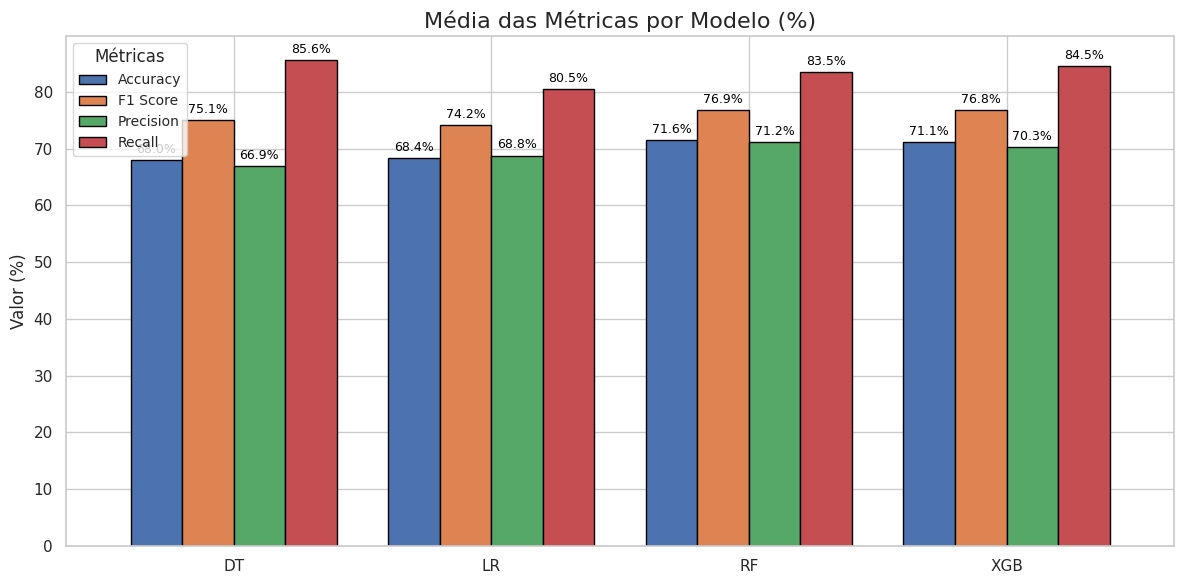

In [ ]:
sns.set(style="whitegrid")


df_plot = model_means.T * 100


ax = df_plot.plot(kind='bar', figsize=(12, 6), width=0.8, edgecolor='black')


plt.title('Média das Métricas por Modelo (%)', fontsize=16)
plt.ylabel('Valor (%)', fontsize=12)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title='Métricas', fontsize=10)


for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 3),
                textcoords='offset points')

plt.tight_layout()

caminho_grafico = "/content/drive/MyDrive/Pesquisa/Código/Aplicação/Green AI/model_metrics_barplot_greenAI.png"
plt.savefig(caminho_grafico, bbox_inches='tight', dpi=300)

plt.show()

## Comparação (F1-Score vs Sustentabilidade)

In [ ]:
resultados = []


modelos = [
    ("Decision Tree", metrics_DT, time_train_DT, emissoes_train_DT),
    ("Random Forest", metrics_RF, time_train_RF, emissoes_train_RF),
    ("XGBoost", metrics_XGB, time_train_XGB, emissoes_train_XGB),
    ("Logistic Regression", metrics_LR, time_train_LR, emissoes_train_LR)
]

for modelo_nome, metrics, tempo, emissoes in modelos:
    n_folds = len(metrics)
    for fold in range(n_folds):
        entrada = {
            "Modelo": modelo_nome,
            "Fold": fold + 1,
            "Fase": "treino",
            "Accuracy": metrics[fold]["Accuracy"],
            "F1 Score": metrics[fold]["F1 Score"],
            "Precision,": metrics[fold]["Precision"],
            "Recall": metrics[fold]["Recall"],
            "Tempo (s)": tempo[fold],
            "Consumo de Energia (kWh)": emissoes[fold]["Energy consumption (kWh)"],
            "Emissões de Carbono (kg CO2)": emissoes[fold]["Carbon Emissions (kg CO2)"],
            "Uso de CPU (kWh)": emissoes[fold]["CPU usage (kWh)"],
            "Uso de GPU (%)": emissoes[fold]["GPU usage (%)"],
            "Uso de Memória (kWh)": emissoes[fold]["Memory usage (kWh)"]
        }
        resultados.append(entrada)

df_resultados = pd.DataFrame(resultados)


colunas_numericas = df_resultados.select_dtypes(include="number").columns
df_resultados[colunas_numericas] = df_resultados[colunas_numericas].round(6)

print(df_resultados)


                 Modelo  Fold    Fase  Accuracy  F1 Score  Precision,  \
0         Decision Tree     1  treino  0.681349  0.759634    0.662586   
1         Decision Tree     2  treino  0.673967  0.745746    0.666418   
2         Decision Tree     3  treino  0.680841  0.751833    0.668869   
3         Decision Tree     4  treino  0.679071  0.751101    0.667101   
4         Decision Tree     5  treino  0.684629  0.747886    0.682462   
5         Random Forest     1  treino  0.718149  0.770258    0.714739   
6         Random Forest     2  treino  0.711098  0.765786    0.706335   
7         Random Forest     3  treino  0.719784  0.770831    0.714607   
8         Random Forest     4  treino  0.715009  0.768376    0.708827   
9         Random Forest     5  treino  0.715421  0.767404    0.713463   
10              XGBoost     1  treino  0.711933  0.769150    0.703561   
11              XGBoost     2  treino  0.705623  0.765656    0.695606   
12              XGBoost     3  treino  0.713280  0.

In [ ]:
df_resultados.to_csv("/content/drive/MyDrive/Pesquisa/Código/Aplicação/Green AI/resultados.csv", index=False)

In [ ]:
resultados = pd.read_csv("/content/drive/MyDrive/Pesquisa/Código/Aplicação/Green AI/resultados.csv")

In [ ]:
resultados

,Modelo,Fold,Fase,Accuracy,F1 Score,"Precision,",Recall,Tempo (s),Consumo de Energia (kWh),Emissões de Carbono (kg CO2),Uso de CPU (kWh),Uso de GPU (%),Uso de Memória (kWh)
0,Decision Tree,1,treino,0.681349,0.759634,0.662586,0.889988,2.841941,0.000021,0.000006,0.000017,0,0.000004
1,Decision Tree,2,treino,0.673967,0.745746,0.666418,0.846513,2.644455,0.000019,0.000005,0.000015,0,0.000004
2,Decision Tree,3,treino,0.680841,0.751833,0.668869,0.858291,2.940357,0.000023,0.000007,0.000019,0,0.000004
3,Decision Tree,4,treino,0.679071,0.751101,0.667101,0.859303,2.524686,0.000013,0.000004,0.000011,0,0.000003
4,Decision Tree,5,treino,0.684629,0.747886,0.682462,0.827182,2.853909,0.000016,0.000005,0.000013,0,0.000003
5,Random Forest,1,treino,0.718149,0.770258,0.714739,0.835128,32.144039,0.000449,0.000128,0.000364,0,0.000086
6,Random Forest,2,treino,0.711098,0.765786,0.706335,0.836164,32.299606,0.000451,0.000129,0.000365,0,0.000086
7,Random Forest,3,treino,0.719784,0.770831,0.714607,0.836659,33.982696,0.000476,0.000136,0.000385,0,0.000091
8,Random Forest,4,treino,0.715009,0.768376,0.708827,0.838849,31.769971,0.000439,0.000125,0.000356,0,0.000084
9,Random Forest,5,treino,0.715421,0.767404,0.713463,0.830167,31.371286,0.000433,0.000124,0.000351,0,0.000082


modelo mais sustentável

In [ ]:
ranking_media = df_resultados.groupby("Modelo").agg({
    "Consumo de Energia (kWh)": "mean",
    "Emissões de Carbono (kg CO2)": "mean",
    "Accuracy": "mean"
}).sort_values(by="Consumo de Energia (kWh)", ascending=True)

print(ranking_media)



                     Consumo de Energia (kWh)  Emissões de Carbono (kg CO2)  \
Modelo                                                                        
Decision Tree                        0.000018                      0.000005   
Logistic Regression                  0.000056                      0.000016   
XGBoost                              0.000068                      0.000019   
Random Forest                        0.000450                      0.000128   

                     Accuracy  
Modelo                         
Decision Tree        0.679971  
Logistic Regression  0.683775  
XGBoost              0.711405  
Random Forest        0.715892  


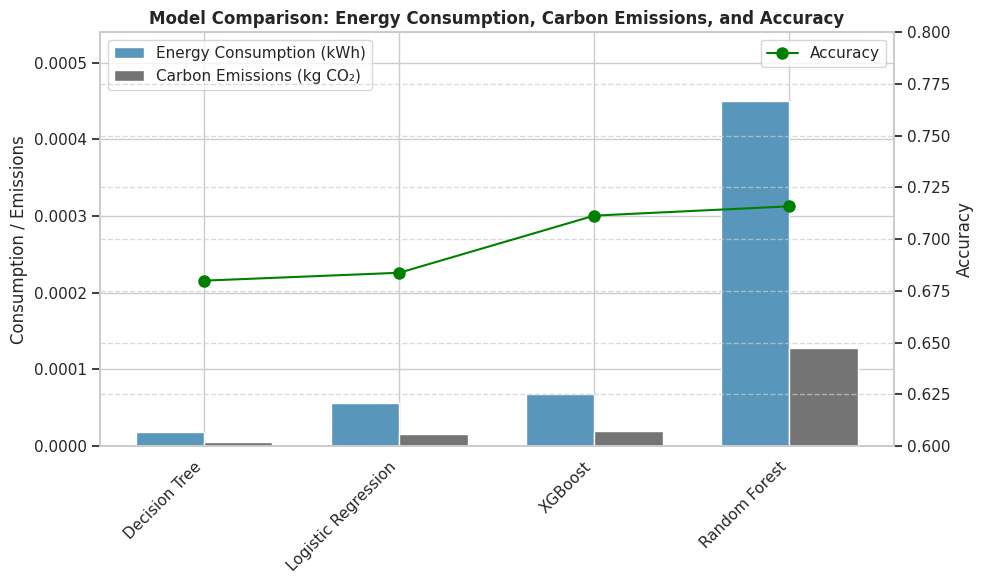

In [ ]:
# Data
models = ranking_media.index
energy_consumption = ranking_media["Consumo de Energia (kWh)"]
carbon_emissions = ranking_media["Emissões de Carbono (kg CO2)"]
Accuracy = ranking_media["Accuracy"]

fig, ax1 = plt.subplots(figsize=(10, 6))

width = 0.35
x = np.arange(len(models))
ax1.bar(x - width/2, energy_consumption, width, label='Energy Consumption (kWh)', color='#5896bb')
ax1.bar(x + width/2, carbon_emissions, width, label='Carbon Emissions (kg CO₂)', color='#747474')
ax1.set_ylabel('Consumption / Emissions', fontsize=12)
ax1.set_ylim(0, max(max(energy_consumption), max(carbon_emissions)) * 1.2)

ax2 = ax1.twinx()
ax2.plot(x, Accuracy, 'o-', color='green', label='Accuracy', markersize=8)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_ylim(0.6, 0.8)

# Final adjustments
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.set_title('Model Comparison: Energy Consumption, Carbon Emissions, and Accuracy', fontweight='bold')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Pesquisa/Código/Aplicação/Green AI/Model_Comparison_GreenAI.png", dpi=300, bbox_inches='tight')
plt.show()
